Want to get rid of systematics from CCDs for weak lensing, so we want the position angle (mod 180 deg) to be as uniform as possible

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from scipy import stats

In [2]:
class uniformKSTest(metrics.BaseMetric):
    """
    Return the KS-test statistic. Values near zero are good, near 1 is bad.
    """
    def __init__(self, paCol = 'rotSkyPos', modVal=180., metricName='uniformKSTest', units='unitless', **kwargs):
        self.paCol = paCol
        self.modVal = modVal
        super(uniformKSTest, self).__init__(col=paCol, metricName=metricName, units=units, **kwargs)
    def run(self, dataSlice, slicePoint=None):
        angleDist = dataSlice[self.paCol] % self.modVal
        ks_D, pVal = stats.kstest(angleDist, 'uniform')
        return ks_D

In [3]:
opsdb = db.OpsimDatabase('minion_1016_sqlite.db')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
slicer = slicers.HealpixSlicer()
sql = 'filter = "g"'
metric = uniformKSTest(modVal=np.pi)
bundle = metricBundles.MetricBundle(metric, slicer, sql)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database with constraint filter = "g"
Found 246667 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "g" constraint now.
monopole: 0.781156  dipole: lon: -49.8814, lat: -3.26781, amp: 0.0736982
Plotting complete.


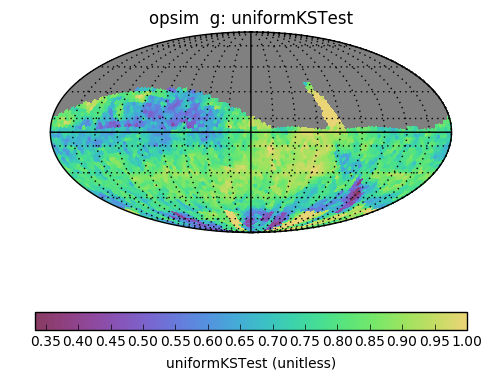

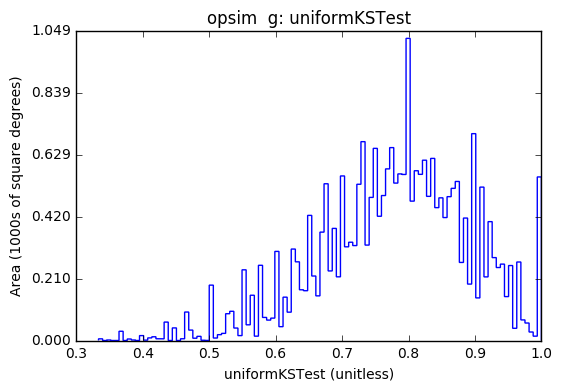

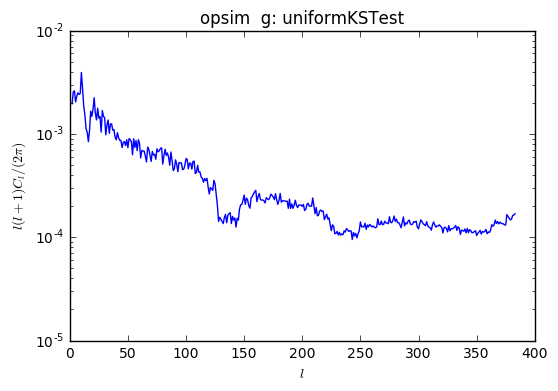

In [5]:
bgroup = metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [6]:
bundle.metricValues.max()

1.0